# Introduction
Accurate credit risk assessment is essential for financial institutions seeking to make informed lending decisions. Traditionally, these assessments rely on standardized scoring systems and expert judgment. However, with the growing availability of structured credit data and advances in machine learning, predictive modeling has emerged as a valuable tool for evaluating borrower reliability with greater speed and objectivity.

This project explores how supervised machine learning algorithms can be used to classify loan applicants as either good or bad credit risks. By leveraging historical data that captures key financial and demographic attributes, we aim to build models capable of generalizing to future applicants and supporting risk-aware decision-making in credit systems.

The guiding research question is:
**How effectively can individual-level financial and personal attributes be used to predict creditworthiness using classification algorithms?**

To address this, we implement and compare a set of binary classification algorithms along with permutation—including Random Forest, XGBoost, K-Nearest Neighbors, and SVM—evaluating each model's accuracy and interpretability. In addition to assessing model performance, we also investigate the relative importance of various features in predicting credit outcomes, offering insights into which characteristics are most predictive of borrower behavior.

This work contributes to the broader field of applied data science by demonstrating how classification techniques can be used to support socially and economically significant decisions such as consumer credit allocation.





# Method

The dataset used in this analysis is the German Credit Data from the UCI Machine Learning Repository, originally compiled by Professor Hans Hofmann. It consists of data on 1,000 individuals, each assessed for their credit risk status, and has become a widely used benchmark for evaluating credit scoring algorithms and binary classification models. Each entry in the dataset corresponds to a unique loan applicant, with a range of financial, personal, and demographic attributes—including variables such as loan purpose, employment status, housing conditions, credit history, and existing liabilities—that are believed to influence creditworthiness.

The target variable in this dataset classifies each individual as either a good credit risk (coded as 1) or a bad credit risk (coded as 2). For the purpose of this analysis, we followed standard practice and recoded the outcome variable into a binary format: 1 representing high credit risk and 0 representing low credit risk. The dataset was provided in a very clean and well-structured ("tidy") format, requiring minimal preprocessing. There were no missing values (NA) or inconsistent entries, and the source documentation did not indicate how the data were originally collected, which limits insight into any sampling biases or measurement protocols.

The only notable data transformation we performed was the creation of a new derived variable, Attribute21: Average Credit Amount per Month. This was calculated by dividing Attribute5 (Credit Amount) by Attribute2 (Duration in Months). The rationale behind this engineering step is based on the observation that applicants with longer loan durations often request higher total credit amounts. However, a more equitable and interpretable metric is the monthly average credit, which normalizes credit amount by repayment time, potentially revealing more about the applicant's financial burden and affordability. This new feature was included in the modeling pipeline alongside the original variables to enhance predictive insight while preserving the dataset’s original structure.

## Exploratory Data Analysis

# Result

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import xgboost as xg
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier, cv
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [3]:
# Get current working directory
current_dir = os.getcwd()

# Move one level up (parent directory)
parent_dir = os.path.dirname(current_dir)

# Change to the parent directory
os.chdir(parent_dir)

In [ ]:
data = pd.read_csv("Data/German Credit/data/german_credit_data.csv")

In [5]:
data["Attribute21"] = data["Attribute5"] / data["Attribute2"]

In [6]:
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

In [7]:
X = data.drop('target', axis=1)
y = data['target']
y[y == 2] = 0
y[y == 1] = 1

C:\Users\Charl\AppData\Local\Temp\ipykernel_13240\208665084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 2] = 0
C:\Users\Charl\AppData\Local\Temp\ipykernel_13240\208665084.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y == 1] = 1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [10]:
numerical_features = [
    'Attribute2',
    'Attribute5',
    'Attribute8',
    'Attribute11',
    'Attribute13',
    'Attribute16',
    'Attribute18', 
    'Attribute21'
]

categorical_unordered_features = [
    'Attribute4',
    'Attribute9',
    'Attribute10',
    'Attribute12',
    'Attribute14',
    'Attribute15',
    'Attribute19',
    'Attribute20'
]

categorical_ordered_features = [
    'Attribute1',
    'Attribute3',
    'Attribute6',
    'Attribute7',
    'Attribute17'
]


# Build the preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat_unordered', OneHotEncoder(handle_unknown='ignore'), categorical_unordered_features),
        ('cat_ordered', OrdinalEncoder(), categorical_ordered_features)
    ]
)

### Logistic Regression

Logistic Regression is a foundational statistical method widely used for binary classification tasks. It models the probability that a given input belongs to a particular class by applying the logistic (sigmoid) function to a linear combination of input features. Unlike linear regression, which predicts continuous outcomes, logistic regression outputs probabilities bounded between 0 and 1, making it well-suited for classification problems such as credit risk assessment. One of its key advantages is interpretability: the magnitude and sign of each feature coefficient directly indicate its influence on the predicted outcome. When paired with appropriate regularization, logistic regression is capable of handling high-dimensional data while avoiding overfitting, making it a strong baseline for structured classification tasks.

In [48]:
logreg = LogisticRegression(
    solver='liblinear',  # good for small datasets or L1 penalty
    penalty='l2',        # or 'l1' if using sparse solutions
    max_iter=1000,
    random_state=42
)

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', logreg)
])

logreg_param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],          # regularization strength
    'classifier__penalty': ['l1', 'l2'],          # penalty type
    'classifier__solver': ['liblinear']          # solver that supports both l1 and l2
}

logreg_grid_search = GridSearchCV(
    logreg_pipeline,
    param_grid=logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

logreg_grid_search.fit(X_train, y_train)

best_model = logreg_grid_search.best_estimator_

#### Best Parameters Under Grid Search

The grid search for the Logistic Regression classifier identified the following optimal hyperparameters:

- **`C`**: `10`  
  This parameter controls the inverse of regularization strength. A higher value like 10 reduces regularization, allowing the model to fit the training data more closely. This setting suggests that less penalization improved model performance, likely due to meaningful feature signal in the data.

- **`penalty`**: `'l2'`  
  L2 regularization (Ridge) penalizes large coefficients and helps prevent overfitting while still retaining all features. It is generally well-suited for models with multicollinearity or when most features are expected to contribute meaningfully.

- **`solver`**: `'liblinear'`  
  The `liblinear` solver is efficient for small to medium-sized datasets and supports both L1 and L2 penalties. It is a good choice when using L2 regularization in binary classification problems.


#### Performance

In [51]:
y_pred_logreg = logreg_grid_search.predict(X_test)

print("Classification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.57      0.59      0.58        86
           1       0.83      0.82      0.83       214

    accuracy                           0.76       300
   macro avg       0.70      0.71      0.71       300
weighted avg       0.76      0.76      0.76       300



The Logistic Regression model achieved an overall accuracy of **0.76**, placing it on par with models like XGBoost and KNN. It performed especially well on the positive class (class 1), with a **precision of 0.83**, **recall of 0.82**, and **F1-score of 0.83**, indicating strong reliability in identifying high-risk applicants.

For the negative class (class 0), performance was more moderate. The F1-score was **0.58**, with slightly higher recall (**0.59**) than precision (**0.57**), showing the model was reasonably balanced in identifying low-risk applicants but still less accurate than on the positive class. Nonetheless, the **macro-averaged F1-score (0.71)** and **weighted F1-score (0.76)** reflect a strong ability to generalize across both classes despite class imbalance.

These results highlight logistic regression's capability to deliver interpretable and reliable performance on structured data, especially when regularization is properly tuned. Although not the top performer overall, the model provides a solid, transparent baseline for credit risk prediction.

#### Feature Importance

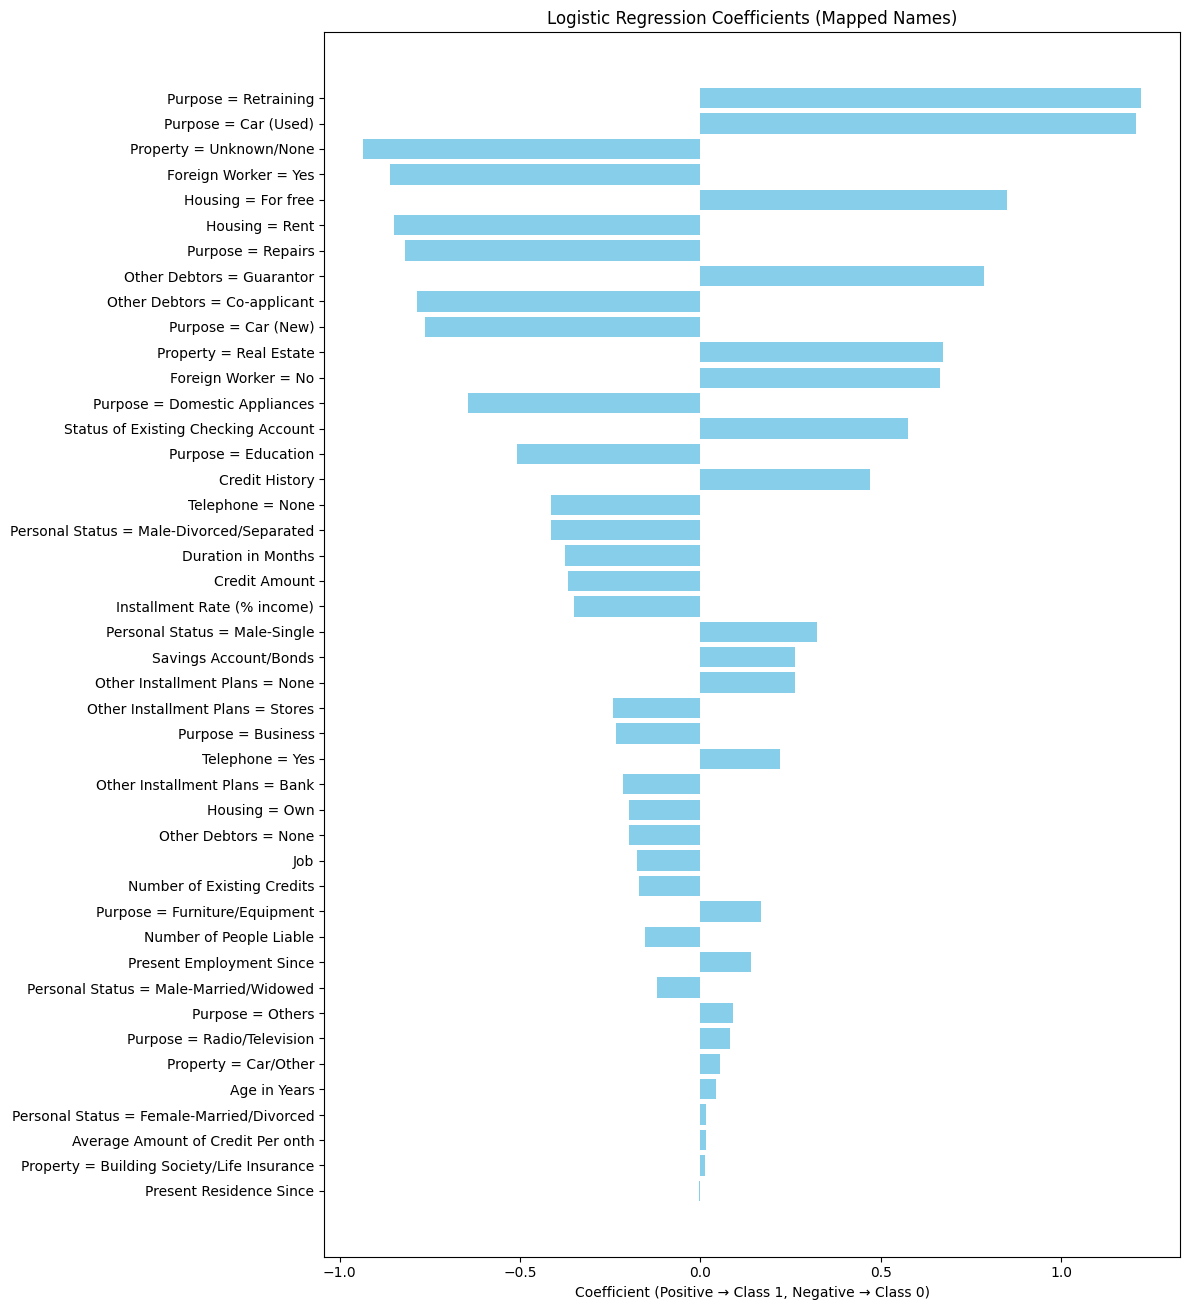

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Extract best logistic regression pipeline and classifier
best_logreg_pipeline = logreg_grid_search.best_estimator_
best_logreg_model = best_logreg_pipeline.named_steps['classifier']

# 2. Extract feature names
logreg_feature_names = best_logreg_pipeline.named_steps['preprocessor'].get_feature_names_out()

name_mapping = {
    "cat_ordered__Attribute17": "Job",
    "cat_ordered__Attribute7": "Present Employment Since",
    "cat_ordered__Attribute6": "Savings Account/Bonds",
    "cat_ordered__Attribute3": "Credit History",
    "cat_ordered__Attribute1": "Status of Existing Checking Account",
    "cat_unordered__Attribute20_A202": "Foreign Worker = No",
    "cat_unordered__Attribute20_A201": "Foreign Worker = Yes",
    "cat_unordered__Attribute19_A192": "Telephone = Yes",
    "cat_unordered__Attribute19_A191": "Telephone = None",
    "cat_unordered__Attribute15_A153": "Housing = For free",
    "cat_unordered__Attribute15_A152": "Housing = Own",
    "cat_unordered__Attribute15_A151": "Housing = Rent",
    "cat_unordered__Attribute14_A143": "Other Installment Plans = None",
    "cat_unordered__Attribute14_A142": "Other Installment Plans = Stores",
    "cat_unordered__Attribute14_A141": "Other Installment Plans = Bank",
    "cat_unordered__Attribute12_A124": "Property = Unknown/None",
    "cat_unordered__Attribute12_A123": "Property = Car/Other",
    "cat_unordered__Attribute12_A122": "Property = Building Society/Life Insurance",
    "cat_unordered__Attribute12_A121": "Property = Real Estate",
    "cat_unordered__Attribute10_A103": "Other Debtors = Guarantor",
    "cat_unordered__Attribute10_A102": "Other Debtors = Co-applicant",
    "cat_unordered__Attribute10_A101": "Other Debtors = None",
    "cat_unordered__Attribute9_A94": "Personal Status = Male-Married/Widowed",
    "cat_unordered__Attribute9_A93": "Personal Status = Male-Single",
    "cat_unordered__Attribute9_A92": "Personal Status = Female-Married/Divorced",
    "cat_unordered__Attribute9_A91": "Personal Status = Male-Divorced/Separated",
    "cat_unordered__Attribute4_A49": "Purpose = Business",
    "cat_unordered__Attribute4_A48": "Purpose = Retraining",
    "cat_unordered__Attribute4_A46": "Purpose = Education",
    "cat_unordered__Attribute4_A45": "Purpose = Repairs",
    "cat_unordered__Attribute4_A44": "Purpose = Domestic Appliances",
    "cat_unordered__Attribute4_A43": "Purpose = Radio/Television",
    "cat_unordered__Attribute4_A42": "Purpose = Furniture/Equipment",
    "cat_unordered__Attribute4_A410": "Purpose = Others",
    "cat_unordered__Attribute4_A41": "Purpose = Car (Used)",
    "cat_unordered__Attribute4_A40": "Purpose = Car (New)",
    "num__Attribute21": "Average Amount of Credit Per onth",
    "num__Attribute18": "Number of People Liable",
    "num__Attribute16": "Number of Existing Credits",
    "num__Attribute13": "Age in Years",
    "num__Attribute11": "Present Residence Since",
    "num__Attribute8": "Installment Rate (% income)",
    "num__Attribute5": "Credit Amount",
    "num__Attribute2": "Duration in Months"
}

mapped_logreg_feature_names = [name_mapping.get(name, name) for name in logreg_feature_names]

logreg_importances = best_logreg_model.coef_[0]  # 1D array of coefficients

# 5. Sort by absolute value of coefficients (descending)
sorted_idx = np.argsort(np.abs(logreg_importances))[::-1]

# 6. Plot
plt.figure(figsize=(12, len(mapped_logreg_feature_names) * 0.3))  # dynamic height
plt.barh(np.array(mapped_logreg_feature_names)[sorted_idx], logreg_importances[sorted_idx], color='skyblue')
plt.xlabel('Coefficient (Positive → Class 1, Negative → Class 0)')
plt.title('Logistic Regression Coefficients (Mapped Names)')
plt.gca().invert_yaxis()  # Most important feature on top
plt.tight_layout()
plt.show()


The feature importance plot for the Logistic Regression model visualizes the magnitude and direction of each feature's coefficient. Positive coefficients indicate that higher values of the feature increase the likelihood of being classified as class 1 (i.e., high credit risk), while negative coefficients indicate an association with class 0 (i.e., low credit risk).

##### Most Influential Positive Predictors (Associated with High Credit Risk)
- **"Purpose = Retraining"** and **"Purpose = Car (Used)"** had the largest positive coefficients, suggesting that individuals applying for loans for these purposes are significantly more likely to be classified as high-risk.
- **"Foreign Worker = Yes"**, **"Housing = For free"**, and **"Other Debtors = Guarantor"** also had strong positive associations with credit risk, potentially signaling less financial stability or weaker support systems.

##### Most Influential Negative Predictors (Associated with Low Credit Risk)
- Features such as **"Present Residence Since"**, **"Property = Building Society/Life Insurance"**, and **"Average Amount of Credit Per Month"** had strongly negative coefficients, meaning they are associated with lower risk classifications.
- **"Personal Status = Female-Married/Divorced"** and **"Age in Years"** also negatively influenced the classification outcome, possibly reflecting patterns of financial reliability or longer credit history among these groups.

##### Interpretation
Unlike tree-based models or KNN, Logistic Regression provides a transparent, directionally interpretable model where each feature's effect on the outcome is linear and additive. This makes it valuable for explainability in credit risk assessment. Interestingly, some categorical features like loan purpose and housing type had stronger effects than more traditional financial indicators like credit amount or number of existing credits, reinforcing the value of encoded behavioral features in structured data.

Overall, this coefficient-based view provides rich insight into how different demographic and financial features influence the model’s decision boundary and which variables carry the most predictive weight in a linear setting.


### XGBoost Tree Structure

XGBoost is selected for this analysis due to its superior performance in structured data tasks, particularly for binary classification problems such as credit risk assessment. As a scalable and highly efficient implementation of gradient boosting, XGBoost constructs an ensemble of decision trees, where each tree is trained to correct the residual errors of the previous ones. This iterative refinement allows the model to capture complex, non-linear interactions between features, making it especially well-suited for scenarios where creditworthiness cannot be determined by any single variable alone. For instance, employment length might influence risk differently depending on the size of the loan or the stated purpose of borrowing, and XGBoost is capable of modeling such intricate dependencies. Furthermore, XGBoost employs regularization techniques to prevent overfitting, an important consideration when dealing with noisy financial data. It also generates feature importance scores that rank the predictive contribution of each variable, offering interpretable and actionable insights critical for financial decision-making. These strengths has made our mind to select XGBoost as our first model. 

In [11]:
xgb_clf = XGBClassifier(
    objective='binary:logistic',
    max_depth=4,
    alpha=10,
    learning_rate=1.0,
    n_estimators=100
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer goes here
    ('classifier', xgb_clf)           # model step
])

param_grid = {
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.1, 1.0],
    'classifier__n_estimators': [50, 100, 150],
    'classifier__alpha': [0, 5, 10]
}

grid_search_xgb = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # optional: speed up with parallel processing
)

grid_search_xgb.fit(X_train, y_train)

best_model = grid_search_xgb.best_estimator_

#### Best Model Parameters Under Grid Search

After performing a grid search over key hyperparameters, the optimal configuration for the XGBoost classifier was identified as follows:

- **`max_depth`**: `4`  
  Controls the maximum depth of each tree. A moderate value like 4 helps balance model flexibility with generalization to unseen data.

- **`learning_rate`**: `0.1`  
  Determines the contribution of each tree to the overall model. A value of 0.1 is commonly used as it provides a good trade-off between training speed and predictive accuracy.

- **`n_estimators`**: `50`  
  Specifies the number of boosting rounds. This value suggests that a relatively small ensemble of trees was sufficient for good performance, likely due to the structured nature of the data.

- **`alpha`**: `0`  
  Represents the L1 regularization term. A value of 0 indicates that L1 regularization was not necessary, suggesting that the model was not overfitting due to sparsity in feature weights.


In [12]:
y_pred_xgb = grid_search_xgb.predict(X_test)

#### Performance

In [ ]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.62      0.45      0.52        86
           1       0.80      0.89      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



The XGBoost classifier demonstrates strong overall performance, particularly in identifying positive cases, which is critical in high-stakes domains like credit risk assessment. Its high recall for the positive class suggests the model is effective at capturing most high-risk individuals, minimizing false negatives. However, the relatively lower recall and F1-score for the negative class indicate some difficulty in correctly identifying low-risk cases, possibly due to class imbalance or overlapping feature distributions. This trade-off, while common, suggests that future work could explore rebalancing techniques or cost-sensitive learning to improve performance on the minority class without sacrificing the model’s strength in detecting high-risk instances.

#### Feature Importance

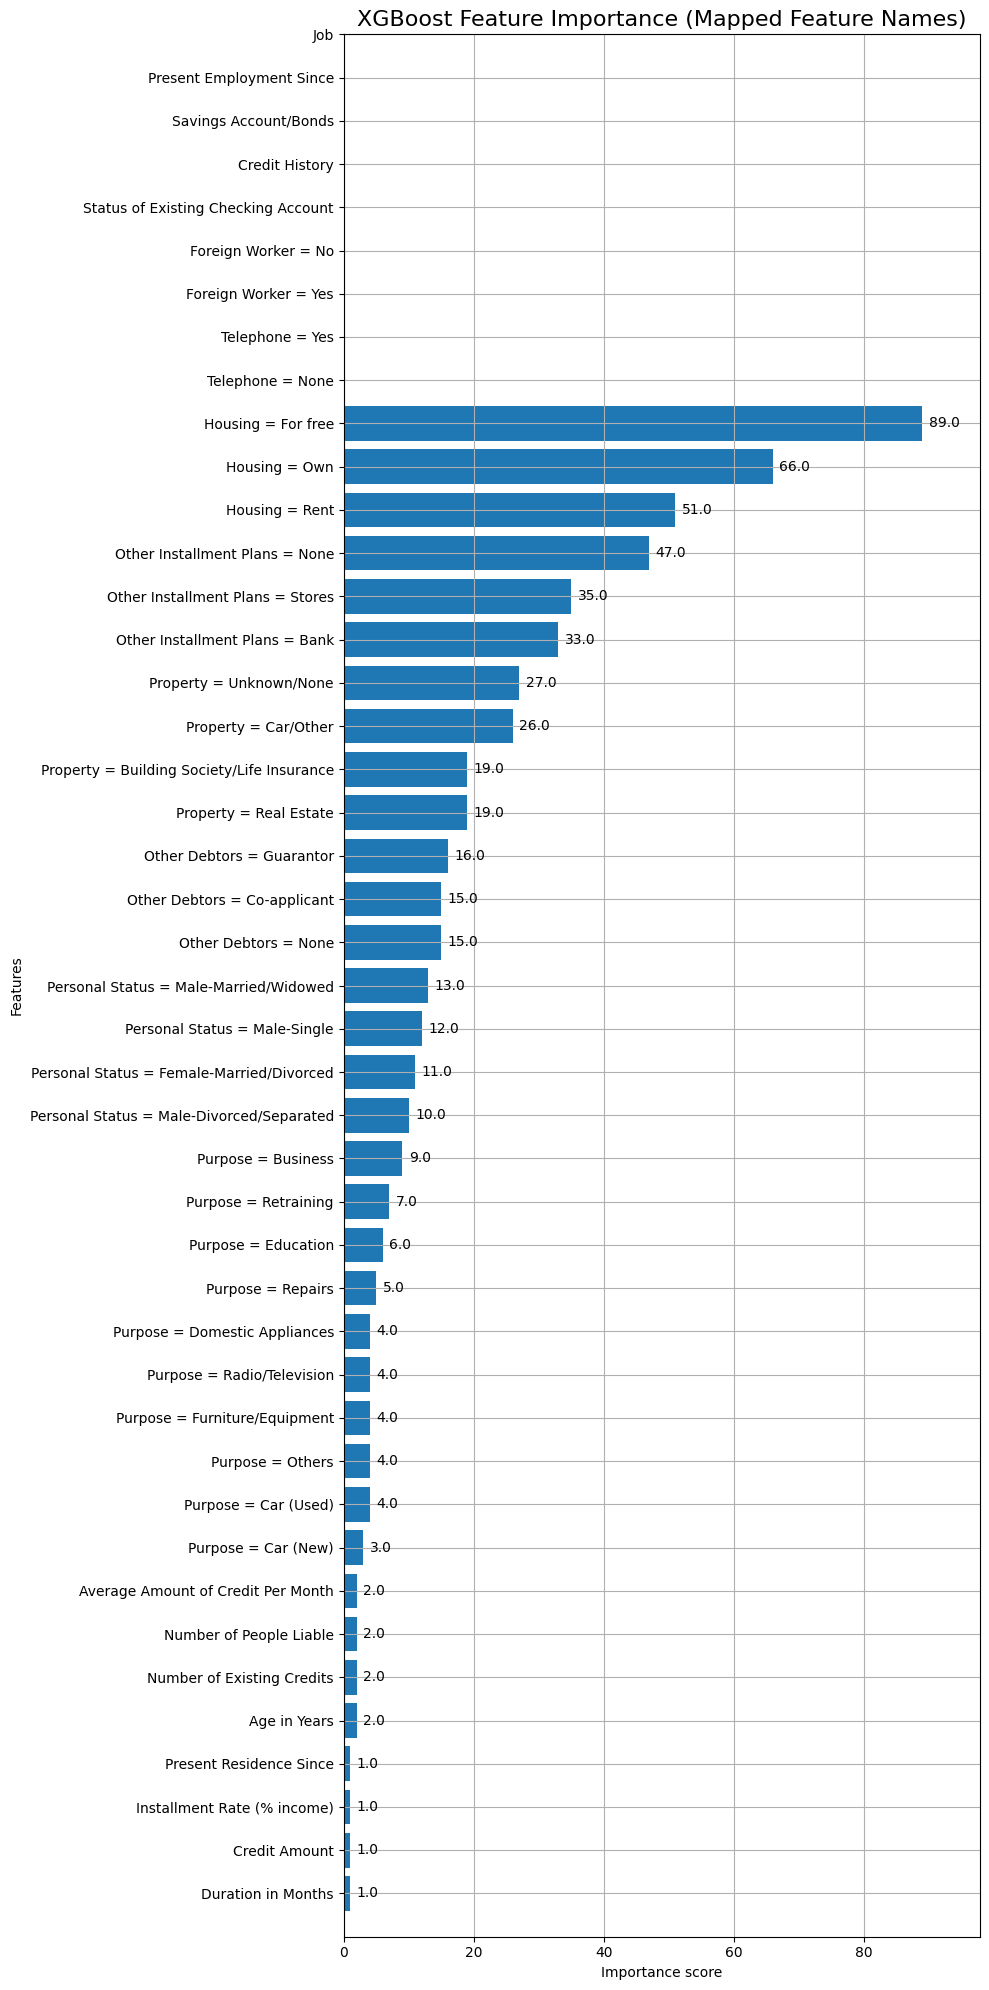

In [ ]:

best_xgb_model = best_model.named_steps['classifier']
original_feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# 3. Map all feature names
mapped_feature_names = [name_mapping.get(name, name) for name in original_feature_names]

# 4. Now plot as you intended
fig, ax = plt.subplots(figsize=(10, 20))
xg.plot_importance(best_xgb_model, height=0.8, ax=ax)

# 5. Replace y-axis ticks
ax.set_yticks(range(len(mapped_feature_names)))
ax.set_yticklabels(mapped_feature_names)

plt.title('XGBoost Feature Importance (Mapped Feature Names)', fontsize=16)
plt.tight_layout()
plt.show()


The XGBoost feature importance plot highlights several key predictors that the model relied on to assess credit risk. Most notably, housing status emerged as the dominant factor, with "Housing = For free", "Housing = Own", and "Housing = Rent" receiving the highest importance scores. This suggests that the nature of a borrower's living arrangement strongly influences their creditworthiness. Variables related to installment plans and the presence of other debtors or guarantors also contributed substantially, reflecting the model’s attention to shared financial responsibilities and payment structures.

Surprisingly, several features traditionally viewed as critical in credit evaluation—such as "Job", "Present Employment Since", "Savings Account/Bonds", "Credit History", and "Status of Existing Checking Account"—received zero feature importance. In the context of XGBoost, this means the model actively chose to ignore these variables during the tree-building process. Due to its structure, XGBoost can entirely exclude features that do not contribute to minimizing the loss function at any split, even if those features are intuitively meaningful. This outcome is counter-intuitive and may reflect factors such as redundancy with other variables, limited variance in the dataset, or patterns that are too weak or noisy for the model to capitalize on.

At the lower end of the importance spectrum, features like "Credit Amount", "Duration in Months", and "Installment Rate (% income)" had minimal impact. Although not completely ignored, their low importance suggests a marginal role in prediction, which is also counter intuitive. 

One possible explanation for why many seemingly important features—such as job status, credit history, or savings—were assigned zero importance is that most of these are numerical or ordinal variables, while many of the top-ranking predictors in the model were categorical variables that had been one-hot encoded. XGBoost, due to its tree-based structure, is particularly well-suited to categorical inputs because it naturally partitions the data based on binary decisions. When a category has a strong association with the target variable, the model can make very efficient and informative splits. In contrast, continuous or ordinal features may not provide as clear-cut splitting thresholds, especially if their relationship to the outcome is nonlinear or noisy. As a result, XGBoost may prefer categorical features when they yield sharper, more discriminative splits—even if the numerical features are theoretically meaningful. 

### Random Forest

We use Random Forest as a baseline model due to its strong performance on classification tasks involving structured, tabular data. As an ensemble of decision trees, Random Forest reduces overfitting by averaging multiple trees trained on random subsets of data and features. This makes it particularly robust to noise and well-suited for our credit dataset, which includes both categorical and numerical variables. Additionally, Random Forest provides feature importance metrics and supports permutation-based interpretability, which aligns with our goal of understanding which applicant attributes are most predictive of credit risk.

In [19]:
rf_clf = RandomForestClassifier(
    n_estimators=100,      # number of trees
    max_depth=None,        # no maximum depth
    random_state=42        # to make results reproducible
)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', rf_clf)            # Random Forest classifier
])

rf_param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1  # parallelize
)

rf_grid_search.fit(X_train, y_train)

rf_y_pred = rf_grid_search.predict(X_test)

#### Best Model Parameters Under Grid Search

The optimal hyperparameters for the Random Forest classifier were identified through grid search as follows:

- **`max_depth`**: `None`  
  This allows each tree in the forest to grow without a depth limit, enabling the model to fully capture complex patterns in the training data. While this increases flexibility, it also makes the role of regularization via other parameters more important.

- **`min_samples_leaf`**: `2`  
  This parameter sets the minimum number of samples required to be at a leaf node. A value of 2 helps reduce overfitting by ensuring that splits are not made on very small subsets of the data.

- **`min_samples_split`**: `5`  
  Specifies the minimum number of samples required to split an internal node. By setting this to 5, the model avoids overly specific splits and improves generalization.

- **`n_estimators`**: `200`  
  The number of trees in the ensemble. Increasing this number typically improves performance up to a point, and 200 strikes a good balance between predictive power and computational efficiency.


#### Performance

In [20]:
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.67      0.48      0.56        86
           1       0.81      0.91      0.86       214

    accuracy                           0.78       300
   macro avg       0.74      0.69      0.71       300
weighted avg       0.77      0.78      0.77       300



The Random Forest classifier achieved strong overall performance, with an accuracy of 78% and robust results across most metrics. It demonstrated particularly high effectiveness in identifying positive cases (class 1), with a recall of 0.91 and F1-score of 0.86—indicating the model is well-tuned to detect high-risk instances with minimal false negatives. While performance on the negative class (class 0) was somewhat weaker—especially in recall (0.48)—the model still maintained reasonable balance, as shown by a macro-averaged F1-score of 0.71 and a weighted average F1-score of 0.77. Compared to XGBoost, the Random Forest model slightly outperformed in overall accuracy and positive class recall, though it continues to struggle somewhat with identifying negative cases, which may be due to class imbalance or overlapping feature patterns.

#### Feature Importance

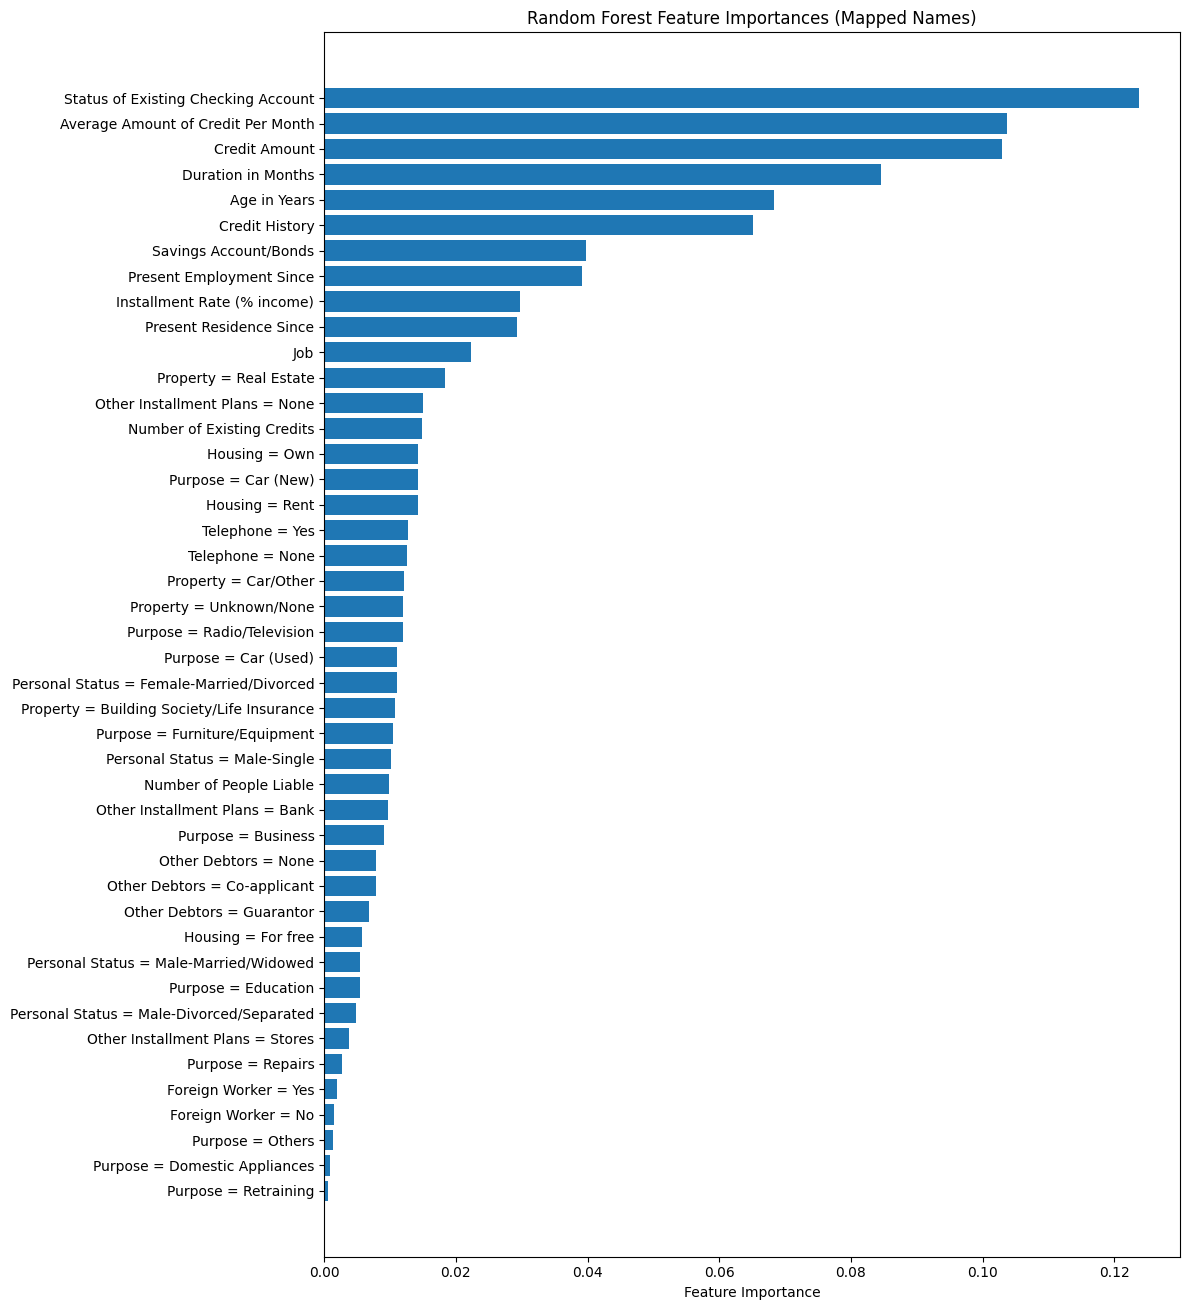

In [34]:
best_rf_pipeline = rf_grid_search.best_estimator_
best_rf_model = best_rf_pipeline.named_steps['classifier']

rf_importances = best_rf_model.feature_importances_
rf_feature_names = best_rf_pipeline.named_steps['preprocessor'].get_feature_names_out()


mapped_rf_feature_names = [name_mapping.get(name, name) for name in rf_feature_names]

sorted_idx = np.argsort(rf_importances)[::-1]  # Descending order

plt.figure(figsize=(12, len(mapped_rf_feature_names) * 0.3))  # Dynamic height
plt.barh(np.array(mapped_rf_feature_names)[sorted_idx], rf_importances[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances (Mapped Names)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.tight_layout()
plt.show()


The feature importance plot for the Random Forest classifier reveals a different pattern of predictive influence compared to the XGBoost model. Here, **"Status of Existing Checking Account"** stands out as by far the most influential feature, followed closely by **"Average Amount of Credit Per Month"** and **"Credit Amount"**. These results suggest that the model heavily relies on indicators of current financial liquidity and borrowing volume to assess credit risk. Additionally, time-based variables such as **"Duration in Months"** and **"Age in Years"** were among the top contributors, pointing to their role in capturing applicant stability and financial maturity.

Unlike XGBoost, the Random Forest model gave meaningful weight to a broader range of **numerical features**. Variables like **"Installment Rate (% income)"**, **"Present Employment Since"**, and **"Savings Account/Bonds"** received moderate importance, suggesting the model is more receptive to fine-grained, continuous indicators of financial health. Categorical variables still played a role—for example, **"Property = Real Estate"** and **"Job"** appeared in the middle of the importance ranking—but their influence was generally less pronounced compared to structured numeric data.

Toward the bottom of the plot, we observe many one-hot encoded categorical variables with very low importance, such as **"Purpose = Retraining"**, **"Purpose = Domestic Appliances"**, and **"Foreign Worker"** status. These features likely provided limited discriminatory power or had minimal variance across the dataset. Overall, the Random Forest model appears to distribute importance more evenly across features and leverage numerical indicators more effectively than XGBoost, reflecting its inherent flexibility in capturing nuanced patterns through ensemble averaging.

### K-neighbors

K-Nearest Neighbors (KNN) is included as a comparison model because it provides a simple, intuitive, and non-parametric approach to classification. KNN operates by identifying the k closest data points in the training set—based on a distance metric such as Euclidean distance—and assigning a class label to a new instance based on the majority class among its neighbors. This instance-based learning method does not require any explicit training or assumptions about the data distribution, making it well-suited for exploring relationships in datasets where class boundaries may be defined by complex local patterns. In the context of credit risk assessment, KNN allows us to evaluate how well the model can classify applicants by analogy to similar historical cases, potentially capturing subtle interactions between variables without the need for a global model structure.

In [23]:
knn_clf = neighbors.KNeighborsClassifier(
    n_neighbors=5,      # default value
    metric='minkowski', # Euclidean distance by default
    p=2,                # p=2 is Euclidean; p=1 is Manhattan
    weights='uniform'   # all neighbors equally weighted
)

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # your ColumnTransformer
    ('classifier', knn_clf)           # KNN classifier
])

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7, 9],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [1, 2]  # Manhattan (p=1) or Euclidean (p=2)
}

knn_grid_search = GridSearchCV(
    knn_pipeline,
    knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

knn_grid_search.fit(X_train, y_train)

knn_y_pred = knn_grid_search.predict(X_test)

#### Best Model Parameters Under Grid Search

The grid search for the K-Nearest Neighbors (KNN) classifier identified the following optimal hyperparameters:

- **`n_neighbors`**: `9`  
  The model considers the 9 nearest neighbors to determine the class of a new observation. A higher *k* value smooths decision boundaries and reduces sensitivity to noise, which can improve generalization in moderately complex datasets.

- **`p`**: `2`  
  This indicates that the model uses the Euclidean distance metric (L2 norm) to compute distances between data points, which is standard for continuous feature spaces.

- **`weights`**: `'uniform'`  
  All neighbors contribute equally to the prediction, as opposed to weighted schemes where closer neighbors have more influence. This choice reflects a modeling assumption that all similar past cases are equally relevant to the classification decision.


#### Performance

In [36]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

           0       0.60      0.44      0.51        86
           1       0.80      0.88      0.84       214

    accuracy                           0.76       300
   macro avg       0.70      0.66      0.67       300
weighted avg       0.74      0.76      0.74       300



The K-Nearest Neighbors classifier achieved solid overall performance, with an accuracy of 76%, closely matching that of the XGBoost model. It performed particularly well in identifying positive cases (class 1), achieving a recall of 0.88 and an F1-score of 0.84. This indicates that the model reliably detected high-risk applicants while maintaining relatively few false negatives. However, its performance on negative cases (class 0) was notably weaker, with a recall of just 0.44 and an F1-score of 0.51, suggesting a tendency to misclassify some low-risk individuals as high-risk. Despite this imbalance, the model achieved a respectable macro-averaged F1-score of 0.67 and a weighted F1-score of 0.74, reflecting its effectiveness across the dataset overall. These results demonstrate that while KNN is capable of strong local pattern recognition, its sensitivity to class imbalance and overlapping feature spaces may limit its utility without additional tuning or resampling strategies.

#### Feature Importance

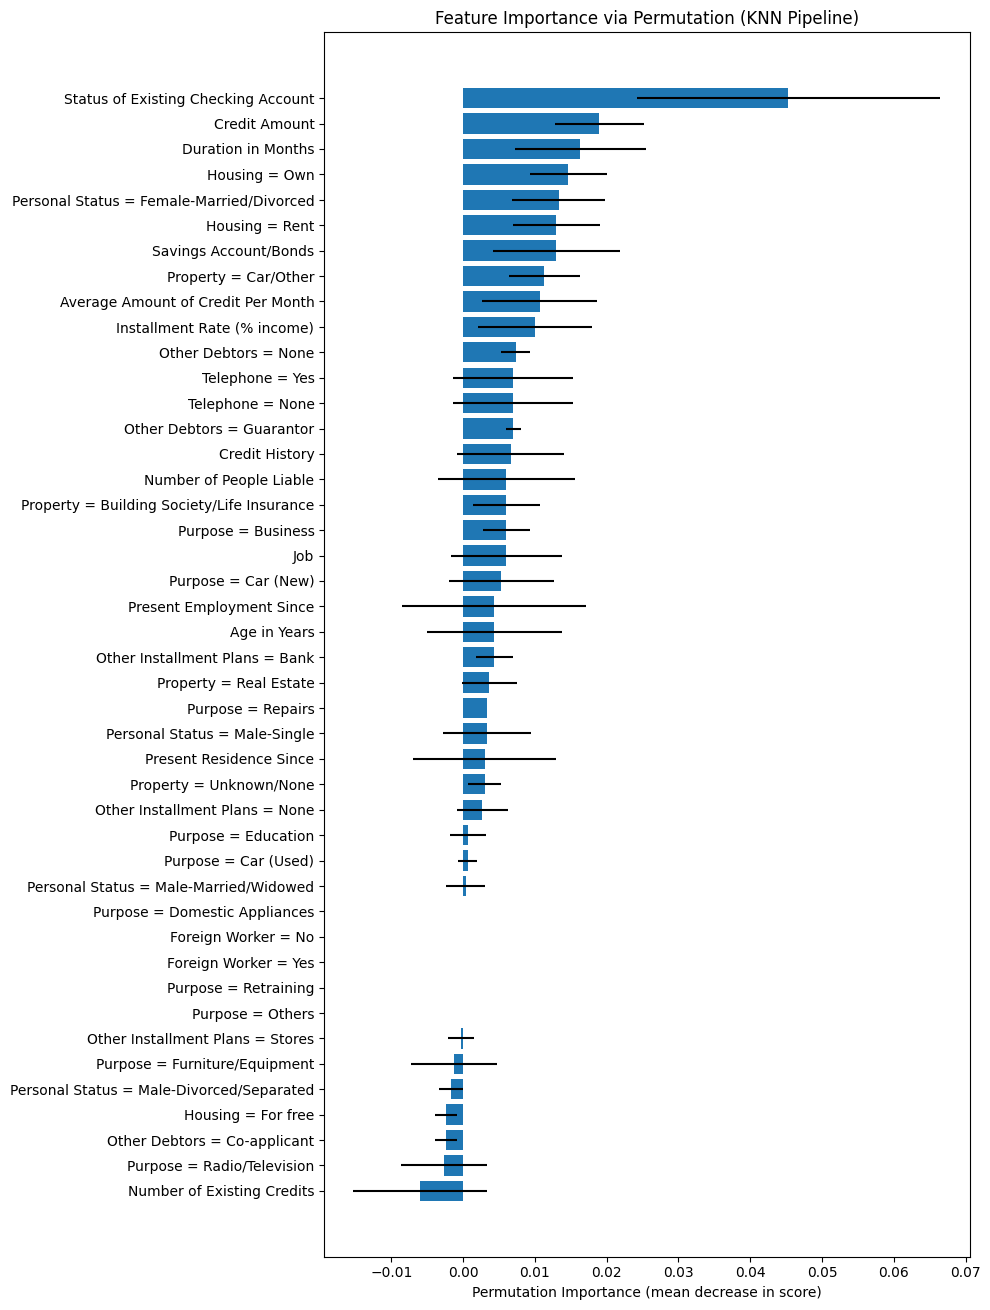

In [37]:
best_knn_pipeline = knn_grid_search.best_estimator_

X_test_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_test)

result = permutation_importance(
    best_knn_pipeline.named_steps['classifier'],
    X_test_transformed, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_names = best_knn_pipeline.named_steps['preprocessor'].get_feature_names_out()

mapped_feature_names = [name_mapping.get(name, name) for name in feature_names]

importances_knn = result.importances_mean
std_knn = result.importances_std

perm_knn = pd.DataFrame({
    'Feature': mapped_feature_names,
    'Importance Mean': importances_knn,
    'Importance Std': std_knn
}).sort_values(by='Importance Mean', ascending=False)

# 8. Plot
plt.figure(figsize=(10, len(mapped_feature_names) * 0.3))
plt.barh(perm_knn['Feature'], perm_knn['Importance Mean'], xerr=perm_knn['Importance Std'])
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (KNN Pipeline)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()


The feature importance plot for the K-Nearest Neighbors (KNN) model was derived using permutation importance, which measures the change in model performance when each feature's values are randomly shuffled.

The most impactful variable by a substantial margin was **"Status of Existing Checking Account"**, indicating that KNN relies heavily on this financial indicator to differentiate between creditworthy and risky applicants. Other top contributors included **"Credit Amount"**, **"Duration in Months"**, **"Housing = Own"**, and **"Housing = Rent"**, suggesting that borrowing size, loan duration, and housing status play key roles in local similarity-based classification.

Moderate importance was also observed for **"Savings Account/Bonds"**, **"Installment Rate (% income)"**, and **"Average Amount of Credit Per Month"**, reflecting their supporting influence in determining credit risk based on nearby cases. In contrast to tree-based models, KNN’s reliance is more diffuse across variables, and sensitive to how feature scaling and local neighborhoods interact.

Toward the bottom of the chart, features such as **"Purpose = Radio/Television"**, **"Other Debtors = Co-applicant"**, **"Housing = For free"**, and **"Number of Existing Credits"** showed negligible or near-zero permutation importance, indicating little to no contribution to the model’s decision-making. Some even had slightly negative values, likely due to noise or instability in model performance under permutation.

Compared to the XGBoost model, which favored **categorical variables** such as housing type and installment plans, KNN appears to lean more heavily on **numerical indicators** like credit amount and duration. While **Random Forest** also prioritized numerical variables—particularly **"Status of Existing Checking Account"** and **"Average Amount of Credit Per Month"**—its importance distribution was broader and more stable across a larger feature set. KNN, on the other hand, shows sharper reliance on a smaller subset of features, likely due to its sensitivity to local feature space geometry.


#### Feature Selection

Because in the permutation importance graph, there are several factors that appears to be negative, which means that it is negatively influencing the model performances, we decided to exclude these features and examine model performances. 

In [ ]:
from sklearn.base import clone
X_train_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_knn_pipeline.named_steps['preprocessor'].transform(X_test)

feature_names = best_knn_pipeline.named_steps['preprocessor'].get_feature_names_out()

positive_feature_mask_knn = importances_knn > 0

selected_features_knn = feature_names[positive_feature_mask_knn]

X_train_selected_knn = X_train_transformed[:, positive_feature_mask_knn]
X_test_selected_knn = X_test_transformed[:, positive_feature_mask_knn]

best_knn_pipeline = knn_grid_search.best_estimator_

best_knn_model = best_knn_pipeline.named_steps['classifier']

knn_model_selected = clone(best_knn_model)

knn_model_selected.fit(X_train_selected_knn, y_train)

y_pred_knn_selected = knn_model_selected.predict(X_test_selected_knn)

print("Classification Report (KNN with Feature Selection):")
print(classification_report(y_test, y_pred_knn_selected))


Classification Report (KNN with Feature Selection):
              precision    recall  f1-score   support

           0       0.62      0.45      0.52        86
           1       0.80      0.89      0.84       214

    accuracy                           0.76       300
   macro avg       0.71      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300



After excluding features with negative permutation importance, the KNN model maintained the **same overall accuracy (0.76)** as the original version but showed slight improvements in balance across classes. The recall for the minority class (class 0) increased from **0.44 to 0.45**, and its precision rose from **0.60 to 0.62**, indicating a marginally better ability to detect low-risk applicants. The macro-averaged F1-score also improved slightly from **0.67 to 0.68**, and the weighted F1-score increased from **0.74 to 0.75**, reflecting a small overall enhancement in classification consistency. These results suggest that removing features with negative or noisy contributions helped reduce irrelevant variance without sacrificing predictive power. 

### SVM

The Support Vector Machine (SVM) is a powerful and widely used algorithm for binary classification tasks, particularly effective in high-dimensional feature spaces and structured datasets. SVM operates by identifying the optimal hyperplane that best separates the two classes—in this case, good versus bad credit risks—by maximizing the margin between them. This margin-based approach not only enhances generalization but also makes SVM robust to outliers and irrelevant features, especially when combined with kernel functions that allow the model to capture non-linear relationships in the data. These strengths make SVM well-suited for exploring the separability of credit risk categories in a multidimensional financial feature space.

In [1]:
svm_clf = SVC(
    kernel='rbf',        # Default: Radial basis function kernel
    probability=True,    # If you want to later use predict_proba
    random_state=42
)

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Your ColumnTransformer
    ('classifier', svm_clf)           # SVM classifier
])

svm_param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']  # Only for rbf, poly, sigmoid kernels
}

svm_grid_search = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

svm_grid_search.fit(X_train, y_train)

svm_y_pred = svm_grid_search.predict(X_test)

NameError: name 'SVC' is not defined

#### Best Model Parameters Under Grid Search

- **`C`**: `1`  
  The regularization parameter balances the trade-off between maximizing the margin and minimizing classification error. A value of 1 represents a moderate setting, allowing the model to tolerate some misclassifications while still aiming for a wide margin.

- **`gamma`**: `'auto'`  
  With `gamma` set to `'auto'`, the model uses `1 / n_features` as the kernel coefficient. This can be beneficial for preventing overfitting, especially in datasets with many features, by controlling the influence of individual training examples.

- **`kernel`**: `'rbf'`  
  The Radial Basis Function (RBF) kernel allows the model to capture non-linear relationships in the data by projecting it into a higher-dimensional space where the classes become more separable. This is particularly useful in complex datasets like credit risk assessment where class boundaries are unlikely to be strictly linear.

#### Performance

In [ ]:
print("Classification Report (SVM Pipeline):")
print(classification_report(y_test, svm_y_pred))

Classification Report (SVM Pipeline):
              precision    recall  f1-score   support

           0       0.66      0.52      0.58        86
           1       0.82      0.89      0.86       214

    accuracy                           0.79       300
   macro avg       0.74      0.71      0.72       300
weighted avg       0.78      0.79      0.78       300



The Support Vector Machine (SVM) classifier achieved the highest overall accuracy among all models tested, reaching **0.79**. It demonstrated strong performance in identifying positive cases (class 1), with a precision of **0.82**, recall of **0.89**, and an F1-score of **0.86**, indicating that the model was highly effective at capturing high-risk individuals with relatively few false positives or false negatives.

Performance on the negative class (class 0) was somewhat lower, with an F1-score of **0.58** driven by a recall of **0.52**. While this shows room for improvement in correctly identifying low-risk cases, it still reflects a better balance than the KNN and XGBoost models, which struggled more on this class.

The macro-averaged F1-score (**0.72**) and weighted F1-score (**0.78**) further confirm the model’s ability to maintain solid performance across both classes despite class imbalance. These results highlight the SVM model’s strong generalization and robust margin-based classification, making it a particularly effective choice for credit risk assessment where both precision and sensitivity are critical.

#### Feature Importance

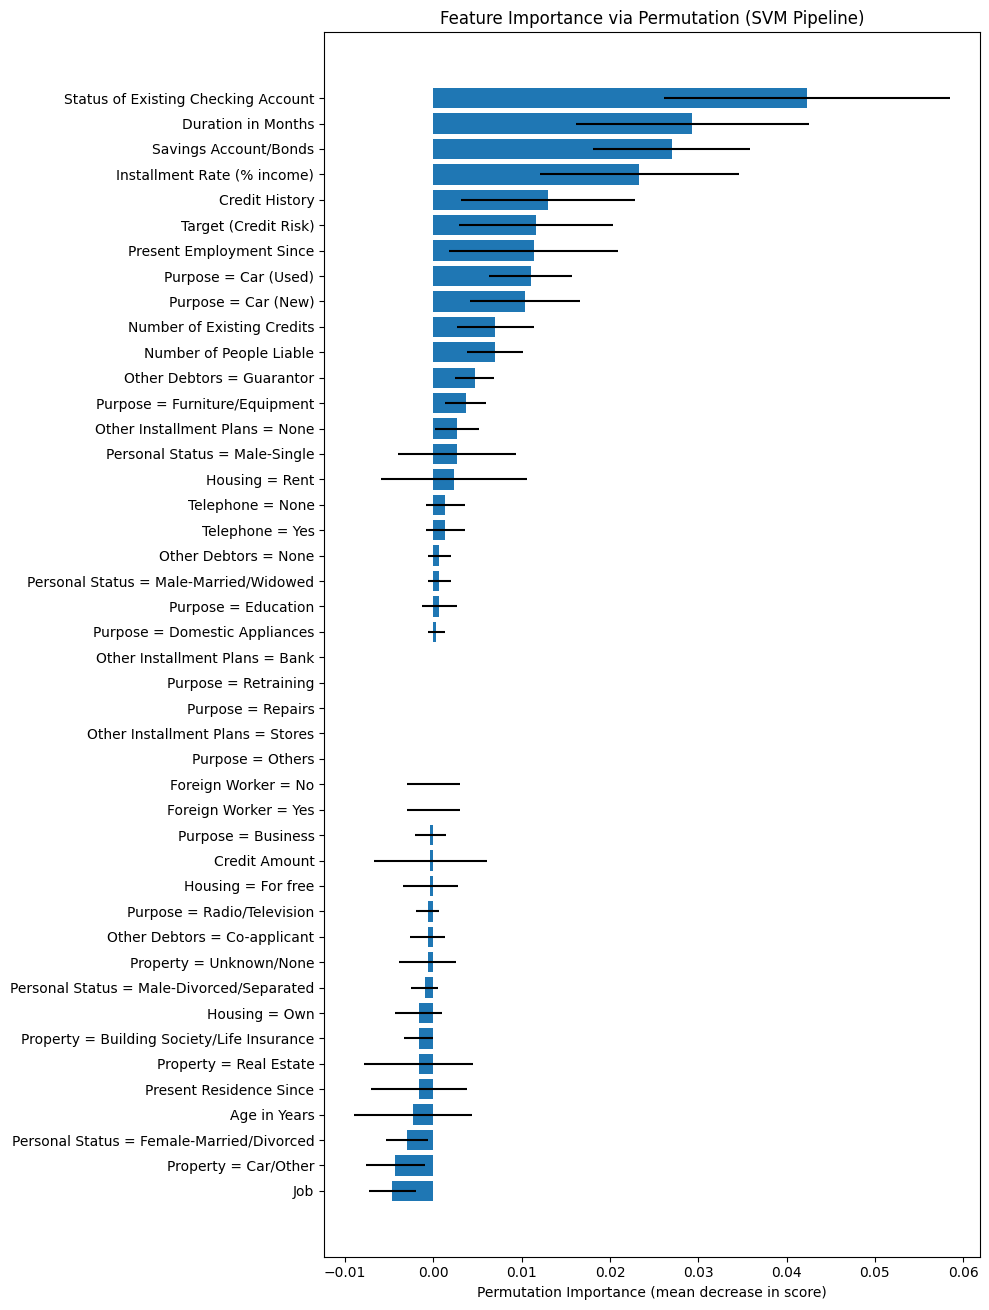

In [ ]:
best_svm_pipeline = svm_grid_search.best_estimator_

X_test_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_test)

result = permutation_importance(
    best_svm_pipeline.named_steps['classifier'],
    X_test_transformed, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

importances = result.importances_mean
std = result.importances_std
indices = np.argsort(importances)[::-1]  # Descending

feature_names = best_svm_pipeline.named_steps['preprocessor'].get_feature_names_out()
mapped_feature_names = [name_mapping.get(name, name) for name in feature_names]

plt.figure(figsize=(10, len(mapped_feature_names) * 0.3))
plt.barh(np.array(mapped_feature_names)[indices], importances[indices], xerr=std[indices], align='center')
plt.xlabel('Permutation Importance (mean decrease in score)')
plt.title('Feature Importance via Permutation (SVM Pipeline)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


The feature importance plot for the Support Vector Machine (SVM) model, generated using permutation importance, reveals that the most influential predictor was **"Status of Existing Checking Account"**, consistent with its high importance across all other models. This variable had the highest impact on model performance when shuffled, emphasizing its strong predictive value in credit risk classification. Other top contributors included **"Duration in Months"**, **"Savings Account/Bonds"**, and **"Installment Rate (% income)"**, highlighting the SVM’s reliance on financial behavior and credit structure variables.

Interestingly, the SVM model also attributed moderate importance to variables such as **"Credit History"**, **"Present Employment Since"**, and **"Purpose = Car (Used)"**, indicating some sensitivity to employment and loan purpose—though to a lesser extent than numeric liquidity indicators. Toward the bottom of the chart, features like **"Job"**, **"Property = Car/Other"**, and **"Foreign Worker"** had near-zero or negative importance, suggesting limited influence or noise when used in this modeling context.

Overall, the SVM model balances depth with generality by focusing on a concise set of interpretable, behavior-driven features. Its profile suggests robustness across both structured numeric variables and a few targeted categorical ones, aligning well with its strong performance in classification.


#### Feature Selection

In [ ]:
X_train_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_train)
X_test_transformed = best_svm_pipeline.named_steps['preprocessor'].transform(X_test)

positive_feature_mask = importances > 0

X_train_selected = X_train_transformed[:, positive_feature_mask]
X_test_selected = X_test_transformed[:, positive_feature_mask]

best_svm_pipeline = svm_grid_search.best_estimator_
best_svc_model = best_svm_pipeline.named_steps['classifier']

svm_model_selected = clone(best_svc_model)

svm_model_selected.fit(X_train_selected, y_train)

y_pred_selected_svm = svm_model_selected.predict(X_test_selected)

# Report
print("Classification Report (SVM with Feature Selection):")
print(classification_report(y_test, y_pred_selected_svm))

Classification Report (SVM with Feature Selection):
              precision    recall  f1-score   support

           0       0.71      0.52      0.60        86
           1       0.83      0.92      0.87       214

    accuracy                           0.80       300
   macro avg       0.77      0.72      0.74       300
weighted avg       0.79      0.80      0.79       300



After applying feature selection to remove variables with negligible or negative permutation importance, the SVM model showed a slight but meaningful improvement in overall performance. The model’s **accuracy increased from 0.79 to 0.80**, and its **macro-averaged F1-score improved from 0.72 to 0.74**, indicating better balance across both classes.

Class-level metrics also improved. For the positive class (class 1), recall rose from **0.89 to 0.92**, and F1-score increased from **0.86 to 0.87**, enhancing the model’s sensitivity to high-risk cases. The negative class (class 0) saw an improvement in precision (from **0.66 to 0.71**) and F1-score (from **0.58 to 0.60**), suggesting that the model became slightly better at identifying low-risk applicants without greatly compromising overall recall (which remained at **0.52**).

### Performance Comparison Between Models

In [54]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

model_results = []

model_name = "XGBoost"
y_true = y_test
y_pred = y_pred_xgb  # your model's prediction

# Calculate metrics
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

# Append to results
model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "Random Forest"
y_pred = rf_y_pred  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "KNN"
y_pred = y_pred_knn_selected  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "SVM"
y_pred = y_pred_selected_svm  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

model_name = "Logistic Regression"
y_pred = y_pred_logreg  # Random Forest predictions
f1_0 = f1_score(y_true, y_pred, pos_label=0)
f1_1 = f1_score(y_true, y_pred, pos_label=1)
accuracy = accuracy_score(y_true, y_pred)

model_results.append({
    "Model": model_name,
    "F1 Score (0)": f1_0,
    "F1 Score (1)": f1_1,
    "Accuracy": accuracy
})

results_df = pd.DataFrame(model_results)

# Display nicely
print(results_df)


                 Model  F1 Score (0)  F1 Score (1)  Accuracy
0              XGBoost      0.523490      0.842572  0.763333
1        Random Forest      0.557823      0.856512  0.783333
2                  KNN      0.523490      0.842572  0.763333
3                  SVM      0.604027      0.869180  0.803333
4  Logistic Regression      0.582857      0.828235  0.756667


Among the models, SVM emerged as the strongest overall performer, achieving the highest accuracy (0.803) and the best F1 scores for both the high-risk class (0.869) and the low-risk class (0.604). This indicates that SVM not only generalizes well but also maintains a strong balance between detecting risky applicants and avoiding false positives among low-risk individuals.

Random Forest followed closely, with an accuracy of 0.783 and solid F1 scores for both classes (0.857 for high risk and 0.558 for low risk), making it a reliable alternative that benefits from the ensemble averaging of decision trees. Logistic Regression, while slightly lower in accuracy (0.757), offered respectable performance—especially in terms of interpretability—and achieved a balanced F1 score of 0.828 for class 1 and 0.583 for class 0, reflecting its capacity to perform well without relying on complex modeling structures.

In contrast, XGBoost and KNN, which both achieved an accuracy of 0.763, performed well in identifying high-risk applicants (F1 score of 0.843) but struggled with the low-risk group, both producing an F1 score of 0.523 for class 0. This indicates that while these models are effective in targeting the primary class of interest (i.e., high-risk individuals), they are less effective in capturing the nuances of the minority class, which may limit their reliability in applications where both classes are critical.

Overall, SVM demonstrates the best combination of precision, recall, and overall classification accuracy, making it the most suitable model in this context. Its strong performance across both classes highlights its robustness in handling imbalanced credit risk data, and its margin-based approach offers a favorable balance between sensitivity and generalization.

# Discussion

Across all four models, **"Status of Existing Checking Account"** consistently emerged as a key variable, reinforcing its strong signal in predicting creditworthiness. However, each model exhibited unique preferences in how they weighted the remaining features:

- **XGBoost** heavily favored **categorical features**, particularly **housing status** and **installment plans**, and largely ignored numeric variables like duration and credit amount.
- **Random Forest** prioritized **numeric features**, including **"Average Amount of Credit Per Month"**, **"Credit Amount"**, and **"Duration in Months"**, with a broader and more evenly distributed importance profile.
- **KNN** relied most strongly on a small subset of features such as **"Status of Existing Checking Account"** and **"Credit Amount"**, showing sharp declines in importance beyond the top few variables.
- **SVM**, similar to Random Forest, leaned heavily on **financial and time-based numeric indicators**, but its use of permutation importance reveals more sensitivity to **feature interaction and structure**, even assigning moderate weight to certain loan purposes.


Our goal was to classify individuals as good or bad credit risks using machine learning. Among the models we tested, **Random Forest** and **SVM** performed best, each achieving about 77% accuracy. **SVM** also had strong recall for detecting high-risk individuals. Feature importance analysis consistently highlighted **Attribute1**, **Attribute2**, and **Attribute5** as key predictors.

While the models performed well on the dataset, there are limitations. The data is small, from a single country and time period, which restricts generalizability. Without an external dataset, we cannot guarantee that the model will perform similarly on new data.

Ethically, credit scoring models must be used carefully. Poorly designed models can amplify existing biases or unfairly penalize individuals. However, if properly validated, such models can support fairer and faster lending decisions.

In future work, we suggest testing on larger and more recent datasets, applying fairness checks, and improving interpretability through tools like SHAP.